In [133]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import glob
warnings.filterwarnings('ignore')
%matplotlib inline

### EDA
- Payment Type
- Order
- Product & Category
- Delivery time & Review score
- Geolocation

### Analytics - Part1 (Cohort, LTV, Retention) 
- Cohort-wise revenue
- Cohort-wise # of clients
- Cohort-wise LTV
- Cohort-wise Retention rate

### Analytics - Part2 (Segmentation)
- RFM
- Elbow method & Silhouette score
- Kmeans & DBSCAN
- Visualization of clusters

### Analytics - Part3 (Churn prediction)
- Define churn and create label
- Comparing various ML models
- Predict customer churn 

*******************************************************************************************************************************************************************

### Data

In [37]:
path = './datasets/'
filenames = glob.glob(path + "*.csv")
file_list = []
for file in sorted(filenames):
    file_list.append(pd.read_csv(file))

In [47]:
customers = file_list[0]
geolocation = file_list[1]
items = file_list[2]
payments = file_list[3]
reviews = file_list[4]
orders = file_list[5]
products = file_list[6]
sellers = file_list[7]
categories = file_list[8]

### Payment Data EDA

In [60]:
# null check
payments.isna().sum()

order_id                0
payment_sequential      0
payment_type            0
payment_installments    0
payment_value           0
dtype: int64

In [63]:
# payment types
payments.payment_type.value_counts()

credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: payment_type, dtype: int64

<AxesSubplot:xlabel='payment_type'>

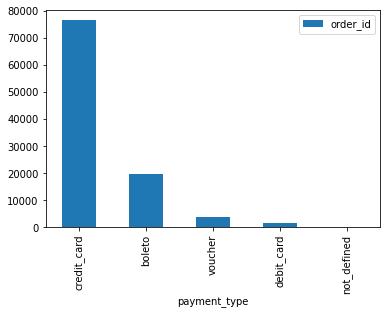

In [76]:
payment_types = payments.groupby('payment_type')[['order_id']].nunique()
payment_types.sort_values('order_id', ascending=False, inplace=True)
payment_types.plot(kind='bar')

In [79]:
# payment installments
installments = payments[payments.payment_type == 'credit_card']

Text(0.5, 1.0, 'Payment installments in credit card')

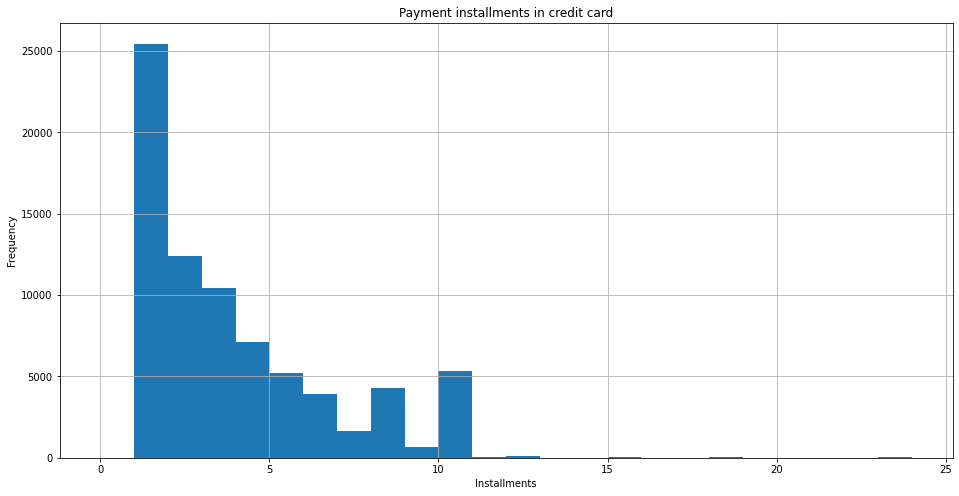

In [91]:
fig, ax = plt.subplots(figsize = (16,8))
installments.hist(column='payment_installments', bins = installments.payment_installments.nunique(), ax=ax)
plt.xlabel("Installments")
plt.ylabel("Frequency")
plt.title("Payment installments in credit card")

In [125]:
# payment value
def detect_outliers(df = payments, col = 'payment_value'):
    q1, q3 = np.percentile(df[col], [25, 75])
    iqr = q3-q1
    lower_bound = q1 - (1.5 * iqr)
    upper_bound = q3 + (1.5 * iqr)
    return df[(df[col] <= upper_bound) & (df[col] >= lower_bound)]

In [130]:
# remove 'not_defined' payment_type class
df_within_outliers = detect_outliers(payments[payments.payment_type != 'not_defined'])

<AxesSubplot:xlabel='payment_value', ylabel='payment_type'>

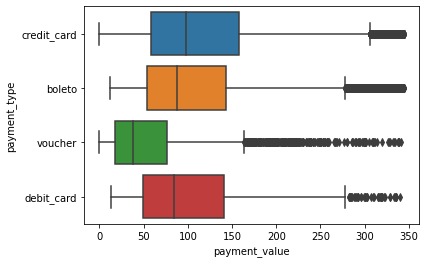

In [132]:
# distributions of payment value in each payment type
sns.boxplot(df_within_outliers, x='payment_value', y='payment_type')

### Order Data EDA